# Spatial deconvolution without reference scRNA-seq

This is a tutorial on an example real Spatial Transcriptomics (ST) data (CID44971_TNBC) from Wu et al., 2021. Raw tutorial could be found in https://starfysh.readthedocs.io/en/latest/notebooks/Starfysh_tutorial_real.html


Starfysh performs cell-type deconvolution followed by various downstream analyses to discover spatial interactions in tumor microenvironment. Specifically, Starfysh looks for anchor spots (presumably with the highest compositions of one given cell type) informed by user-provided gene signatures ([see example](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link)) as priors to guide the deconvolution inference, which further enables downstream analyses such as sample integration, spatial hub characterization, cell-cell interactions, etc. This tutorial focuses on the deconvolution task. Overall, Starfysh provides the following options:

At omicverse, we have made the following improvements:
- Easier visualization, you can use omicverse unified visualization for scientific mapping
- Reduce installation dependency errors, we optimized the automatic selection of different packages, you don't need to install too many extra packages and cause conflicts.

**Base feature**:

- Spot-level deconvolution with expected cell types and corresponding annotated signature gene sets (default)

**Optional**:

- Archetypal Analysis (AA):

    *If gene signatures are not provided*
    
    - Unsupervised cell type annotation

    *If gene signatures are provided but require refinement*:
    
    - Novel cell type / cell state discovery (complementary to known cell types from the *signatures*)
    - Refine known marker genes by appending archetype-specific differentially expressed genes, and update anchor spots accordingly
    
- Product-of-Experts (PoE) integration

    Multi-modal integrative predictions with expression & histology image by leverging additional side information (e.g. cell density) from H&E image.

He, S., Jin, Y., Nazaret, A. et al.
Starfysh integrates spatial transcriptomic and histologic data to reveal heterogeneous tumor–immune hubs.
Nat Biotechnol (2024).
https://doi.org/10.1038/s41587-024-02173-8

In [1]:
import scanpy as sc
import omicverse as ov
ov.plot_set()

2024-08-30 20:13:52.898935: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-30 20:13:52.912560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-30 20:13:52.916671: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-30 20:13:52.927432: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-30 20:13:53.710727: W tensorflow/compiler/tf2


   ____            _     _    __                  
  / __ \____ ___  (_)___| |  / /__  _____________ 
 / / / / __ `__ \/ / ___/ | / / _ \/ ___/ ___/ _ \ 
/ /_/ / / / / / / / /__ | |/ /  __/ /  (__  )  __/ 
\____/_/ /_/ /_/_/\___/ |___/\___/_/  /____/\___/                                              

Version: 1.6.6, Tutorials: https://omicverse.readthedocs.io/
All dependencies are satisfied.


In [2]:
from omicverse.external.starfysh import (AA, utils, plot_utils, post_analysis)
from omicverse.external.starfysh import _starfysh as sf_model

### (1). load data and marker genes

File Input:
- Spatial transcriptomics
    - Count matrix: `adata`
    - (Optional): Paired histology & spot coordinates: `img`, `map_info`

- Annotated signatures (marker genes) for potential cell types: `gene_sig`

Starfysh is built upon scanpy and Anndata. The common ST/Visium data sample folder consists a expression count file (usually `filtered_featyur_bc_matrix.h5`), and a subdirectory with corresponding H&E image and spatial information, as provided by Visium platform.

For example, our example real ST data has the following structure:
```
├── data_folder
    signature.csv

    ├── CID44971:
        \__ filtered_feature_bc_mactrix.h5

        ├── spatial:
            \__ aligned_fiducials.jpg
                detected_tissue_image.jpg
                scalefactors_json.json
                tissue_hires_image.png
                tissue_lowres_image.png
                tissue_positions_list.csv
```

For data that doesn't follow the common visium data structure (e.g. missing `filtered_featyur_bc_matrix.h5` or the given `.h5ad` count matrix file lacks spatial metadata), please construct the data as Anndata synthesizing information as the example simulated data shows:

[Note]: If you’re running this tutorial locally, please download the sample [data](https://drive.google.com/drive/folders/1RIp0Z2eF1m8Ortx0sgB4z5g5ISsRFzJ4?usp=share_link) and [signature gene sets](https://drive.google.com/file/d/1AXWQy_mwzFEKNjAdrJjXuegB3onxJoOM/view?usp=share_link), and save it in the relative path `data/star_data` (otherwise please modify the data_path defined in the cell below):

In [3]:
# Specify data paths
data_path = 'data/star_data'
sample_id = 'CID44971_TNBC'
sig_name = 'bc_signatures_version_1013.csv'

In [4]:
# Load expression counts and signature gene sets
adata, adata_normed = utils.load_adata(data_folder=data_path,
                                       sample_id=sample_id, # sample id
                                       n_genes=2000  # number of highly variable genes to keep
                                       )

[2024-08-30 20:13:55] Preprocessing1: delete the mt and rp


filtered out 269 genes that are detected in less than 1 cells


[2024-08-30 20:13:56] Preprocessing2: Normalize


normalizing counts per cell
    finished (0:00:00)


[2024-08-30 20:13:56] Preprocessing3: Logarithm
[2024-08-30 20:13:56] Preprocessing4: Find the variable genes


extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [5]:
import pandas as pd
import os
gene_sig = pd.read_csv(os.path.join(data_path, sig_name))
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()

Basal     LumA   LumB      MBC Normal epithelial    Tcm      Tem       Tfh  \
0   EMP1  SH3BGRL   UGCG  COL11A2             KRT14   CCR7     IL7R    CXCL13   
1  TAGLN    HSPB1  ARMT1     SDC1             KRT17    LTB    ANXA1       NMB   
2  TTYH1    PHGR1  ISOC1     FBN2               LTF   IL7R    CXCR4     NR3C1   
3   RTN4     SOX9  GDF15     MMP1             KRT15  SARAF    KLRB1     DUSP4   
4    TK1    CEBPD  ZFP36    FABP5               PTN   SELL  TNFAIP3  TNFRSF18   

      Treg Activated CD8  ... Plasmablasts   MDSC Monocytes   cDC     pDC  \
0  TNFRSF4          CD69  ...     IGKV3-15  ITGAM       LYZ  CD80   IL3RA   
1      LTB          CCR7  ...        IGHG1   CD33      IL1B  CD86  LILRA4   
2     IL32          CD27  ...      IGKV1-5   ARG1      G0S2  CCR7   CD123   
3     BATF          BTLA  ...     IGKV3-20   NOS2    TYROBP  CD1A    TCF4   
4    FOXP3        CD40LG  ...     IGKV3-11   CD68      FCN1  CD1C    IRF7   

  CAFs MSC iCAF-like CAFs myCAF-like PVL differentiated PVL immature  \
0               APOD          COL1A1              ACTA2        CCL19   
1                DCN          COL1A2              TAGLN         RGS5   
2              PTGDS          COL3A1               MYL9       IGFBP7   
3                CFD             LUM               TPM2     NDUFA4L2   
4                LUM           SFRP2           NDUFA4L2         CCL2   

  Endothelial  
0       ACKR1  
1       FABP4  
2       PLVAP  
3       RAMP2  
4         VWF  

[5 rows x 29 columns]

**If there's no input signature gene sets, Starfysh defines "archetypal marker genes" as *signatures*. Please refer to the following code snippet and see details in section (3).**

```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig = utils.filter_gene_sig(gene_sig, adata.to_df())
gene_sig.head()
```

computing PCA
    with n_comps=50
    finished (0:00:00)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:05)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:01)


... storing 'sample' as categorical


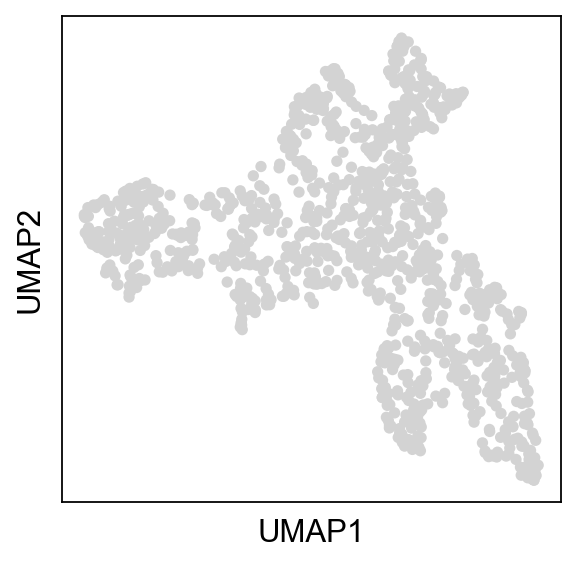

In [6]:
# Load spatial information
img_metadata = utils.preprocess_img(data_path,
                                    sample_id,
                                    adata_index=adata.obs.index,
                                    #hchannel=False
                                    )
img, map_info, scalefactor = img_metadata['img'], img_metadata['map_info'], img_metadata['scalefactor']
umap_df = utils.get_umap(adata, display=True)


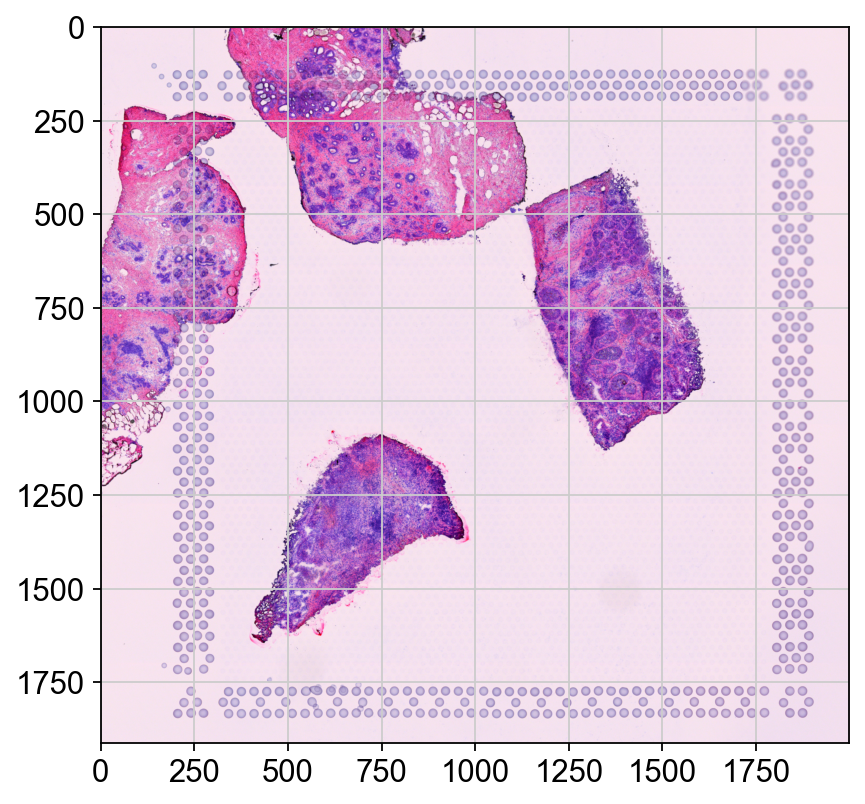

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6), dpi=80)
plt.imshow(img)

In [8]:
map_info.head()

array_row  array_col  imagerow  imagecol         sample
AACATTGGTCAGCCGT-1          3         17      1361      2511  CID44971_TNBC
CATCGAATGGATCTCT-1          3         19      1361      2620  CID44971_TNBC
CGGGTTGTAGCTTTGG-1          3         21      1361      2730  CID44971_TNBC
CCTAAGTGTCTAACCG-1          2         22      1266      2784  CID44971_TNBC
TCTGTGACTGACCGTT-1          3         23      1361      2839  CID44971_TNBC

### (2). Preprocessing (finding anchor spots)
- Identify anchor spot locations.

Instantiate parameters for Starfysh model training:
- Raw & normalized counts after taking highly variable genes
- filtered signature genes
- library size & spatial smoothed library size (log-transformed)
- Anchor spot indices (`anchors_df`) for each cell type & their signature means (`sig_means`)


In [ ]:
# Parameters for training
visium_args = utils.VisiumArguments(adata,
                                    adata_normed,
                                    gene_sig,
                                    img_metadata,
                                    n_anchors=60,
                                    window_size=3,
                                    sample_id=sample_id
                                   )

adata, adata_normed = visium_args.get_adata()
anchors_df = visium_args.get_anchors()

In [10]:
adata.obs['log library size']=visium_args.log_lib
adata.obs['windowed log library size']=visium_args.win_loglib

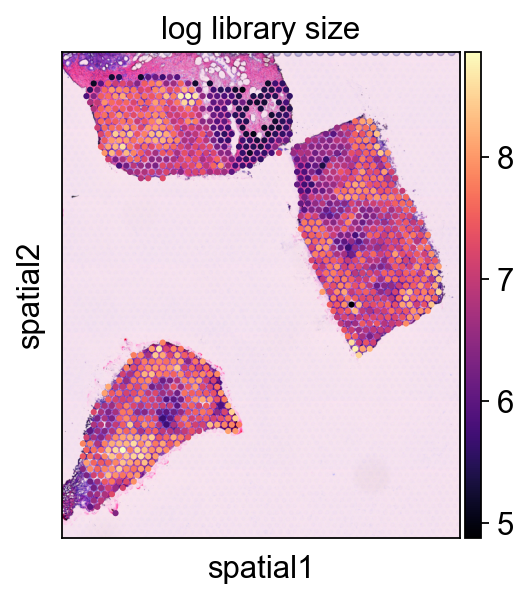

In [11]:
sc.pl.spatial(adata, cmap='magma',
                  # show first 8 cell types
                  color='log library size',
                  ncols=4, size=1.3,
                  img_key='hires',
                  #palette=Layer_color
                  # limit color scale at 99.2% quantile of cell abundance
                  #vmin=0, vmax='p99.2'
                 )

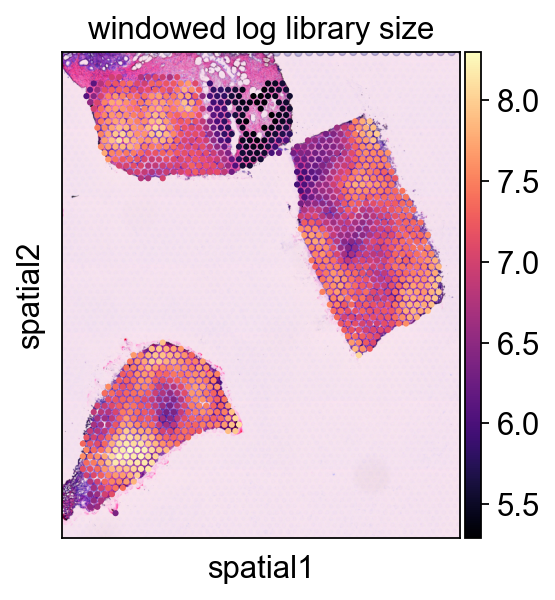

In [12]:
sc.pl.spatial(adata, cmap='magma',
                  # show first 8 cell types
                  color='windowed log library size',
                  ncols=4, size=1.3,
                  img_key='hires',
                  #palette=Layer_color
                  # limit color scale at 99.2% quantile of cell abundance
                  #vmin=0, vmax='p99.2'
                 )

plot raw gene expression:

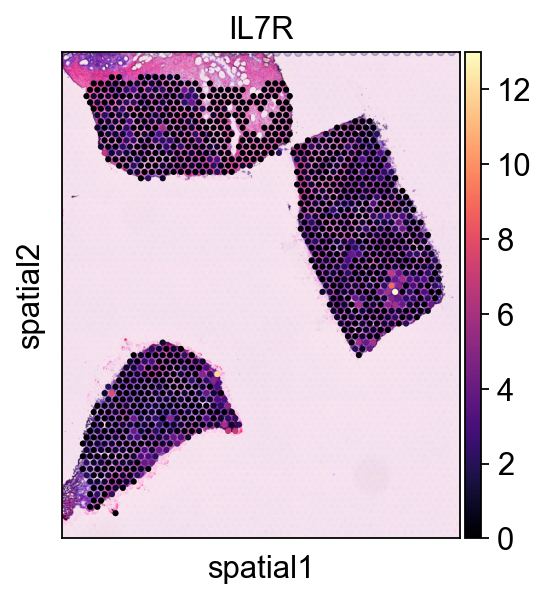

In [13]:
sc.pl.spatial(adata, cmap='magma',
                  # show first 8 cell types
                  color='IL7R',
                  ncols=4, size=1.3,
                  img_key='hires',
                  #palette=Layer_color
                  # limit color scale at 99.2% quantile of cell abundance
                  #vmin=0, vmax='p99.2'
                 )

<AxesSubplot: >

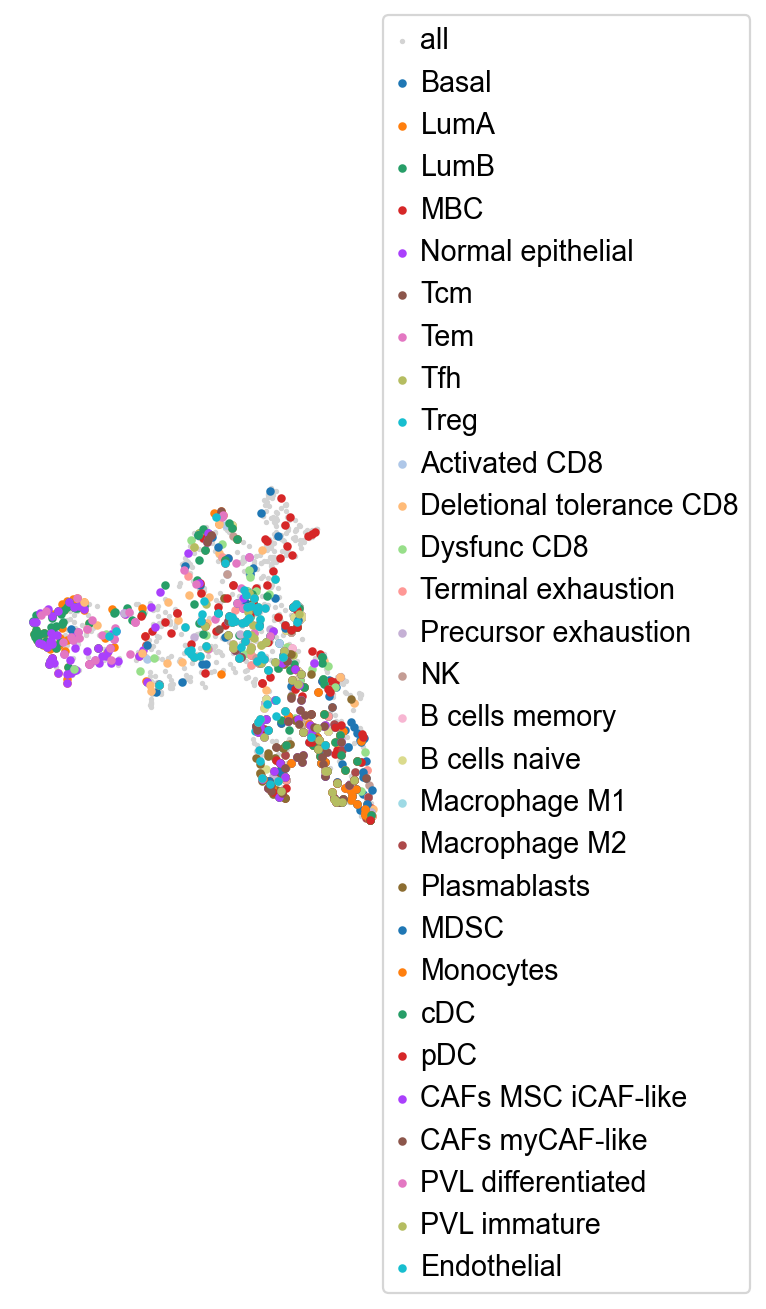

In [14]:
plot_utils.plot_anchor_spots(umap_df,
                             visium_args.pure_spots,
                             visium_args.sig_mean,
                             bbox_x=2
                            )

### (3). Optional: Archetypal Analysis
Overview:
If users don't provide annotated gene signature sets with cell types, Starfysh identifies candidates for cell types via archetypal analysis (AA). The underlying assumption is that the geometric "extremes" are identified as the purest cell types, whereas all other spots are mixture of the "archetypes". If the users provide the gene signature sets, they can still optionally apply AA to refine marker genes and update anchor spots for known cell types. In addition, AA can identify & assign potential novel cell types / states. Here are the features provided by the optional archetypal analysis:
- Finding archetypal spots & assign 1-1 mapping to their closest anchor spot neighbors
- Finding archetypal marker genes & append them to marker genes of annotated cell types
- Assigning novel cell type / cell states as the most distant archetypes

Overall, Starfysh provides the archetypal analysis as a complementary toolkit for automatic cell-type annotation & signature gene completion:<br><br>

1. *If signature genes aren't provided:* <br><br>Archetypal analysis defines the geometric extrema of the data as major cell types with corresponding marker genes.<br><br>

2. *If complete signature genes are known*: <br><br>Users can skip this section and use only the signature priors<br><br>

3. *If signature genes are incomplete or need refinement*: <br><br>Archetypal analysis can be applied to
    a. Refine signatures of certain cell types
    b. Find novel cell types / states that haven't been provided from the input signature

#### If signature genes aren't provided

Note: <br>
- Intrinsic Dimension (ID) estimator is implemented to estimate the lower-bound for the number of archetypes $k$, followed by elbow method with iterations to identify the optimal $k$. By default, a [conditional number](https://scikit-dimension.readthedocs.io/en/latest/skdim.id.FisherS.html) is set as 30; if you believe there are potentially more / fewer cell types, please increase / decrease `cn` accordingly.

Major cell types & corresponding markers are represented by the inferred archetypes:<br><br>



```Python
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(r=40)

# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Define "signature genes" as marker genes associated with each archetypal cluster
gene_sig = aa_model.find_markers(n_markers=30, display=False)
gene_sig.head()
```

#### If complete signature genes are known

Users can skip th section & run Starfysh

#### If signature genes are incomplete or require refinement

**In this tutorial, we'll show an example of applying best-aligned archetypes to existing `anchors` of given cell type(s) to append signature genes.**

In [ ]:
aa_model = AA.ArchetypalAnalysis(adata_orig=adata_normed)
archetype, arche_dict, major_idx, evs = aa_model.compute_archetypes(cn=40)
# (1). Find archetypal spots & archetypal clusters
arche_df = aa_model.find_archetypal_spots(major=True)

# (2). Find marker genes associated with each archetypal cluster
markers_df = aa_model.find_markers(n_markers=30, display=False)

# (3). Map archetypes to closest anchors (1-1 per cell type)
map_df, map_dict = aa_model.assign_archetypes(anchors_df)

# (4). Optional: Find the most distant archetypes that are not assigned to any annotated cell types
distant_arches = aa_model.find_distant_archetypes(anchors_df, n=3)

<AxesSubplot: xlabel='ks', ylabel='Explained Variance'>

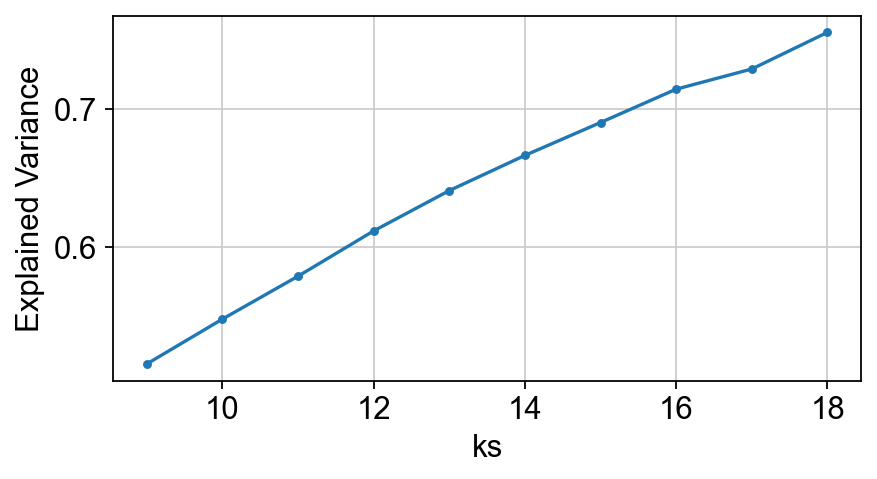

In [16]:
plot_utils.plot_evs(evs, kmin=aa_model.kmin)

- Visualize archetypes

[2024-08-30 20:15:03] Calculating UMAPs for counts + Archetypes...
[2024-08-30 20:15:10] No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


(<Figure size 1800x1200 with 1 Axes>, <AxesSubplot: >)

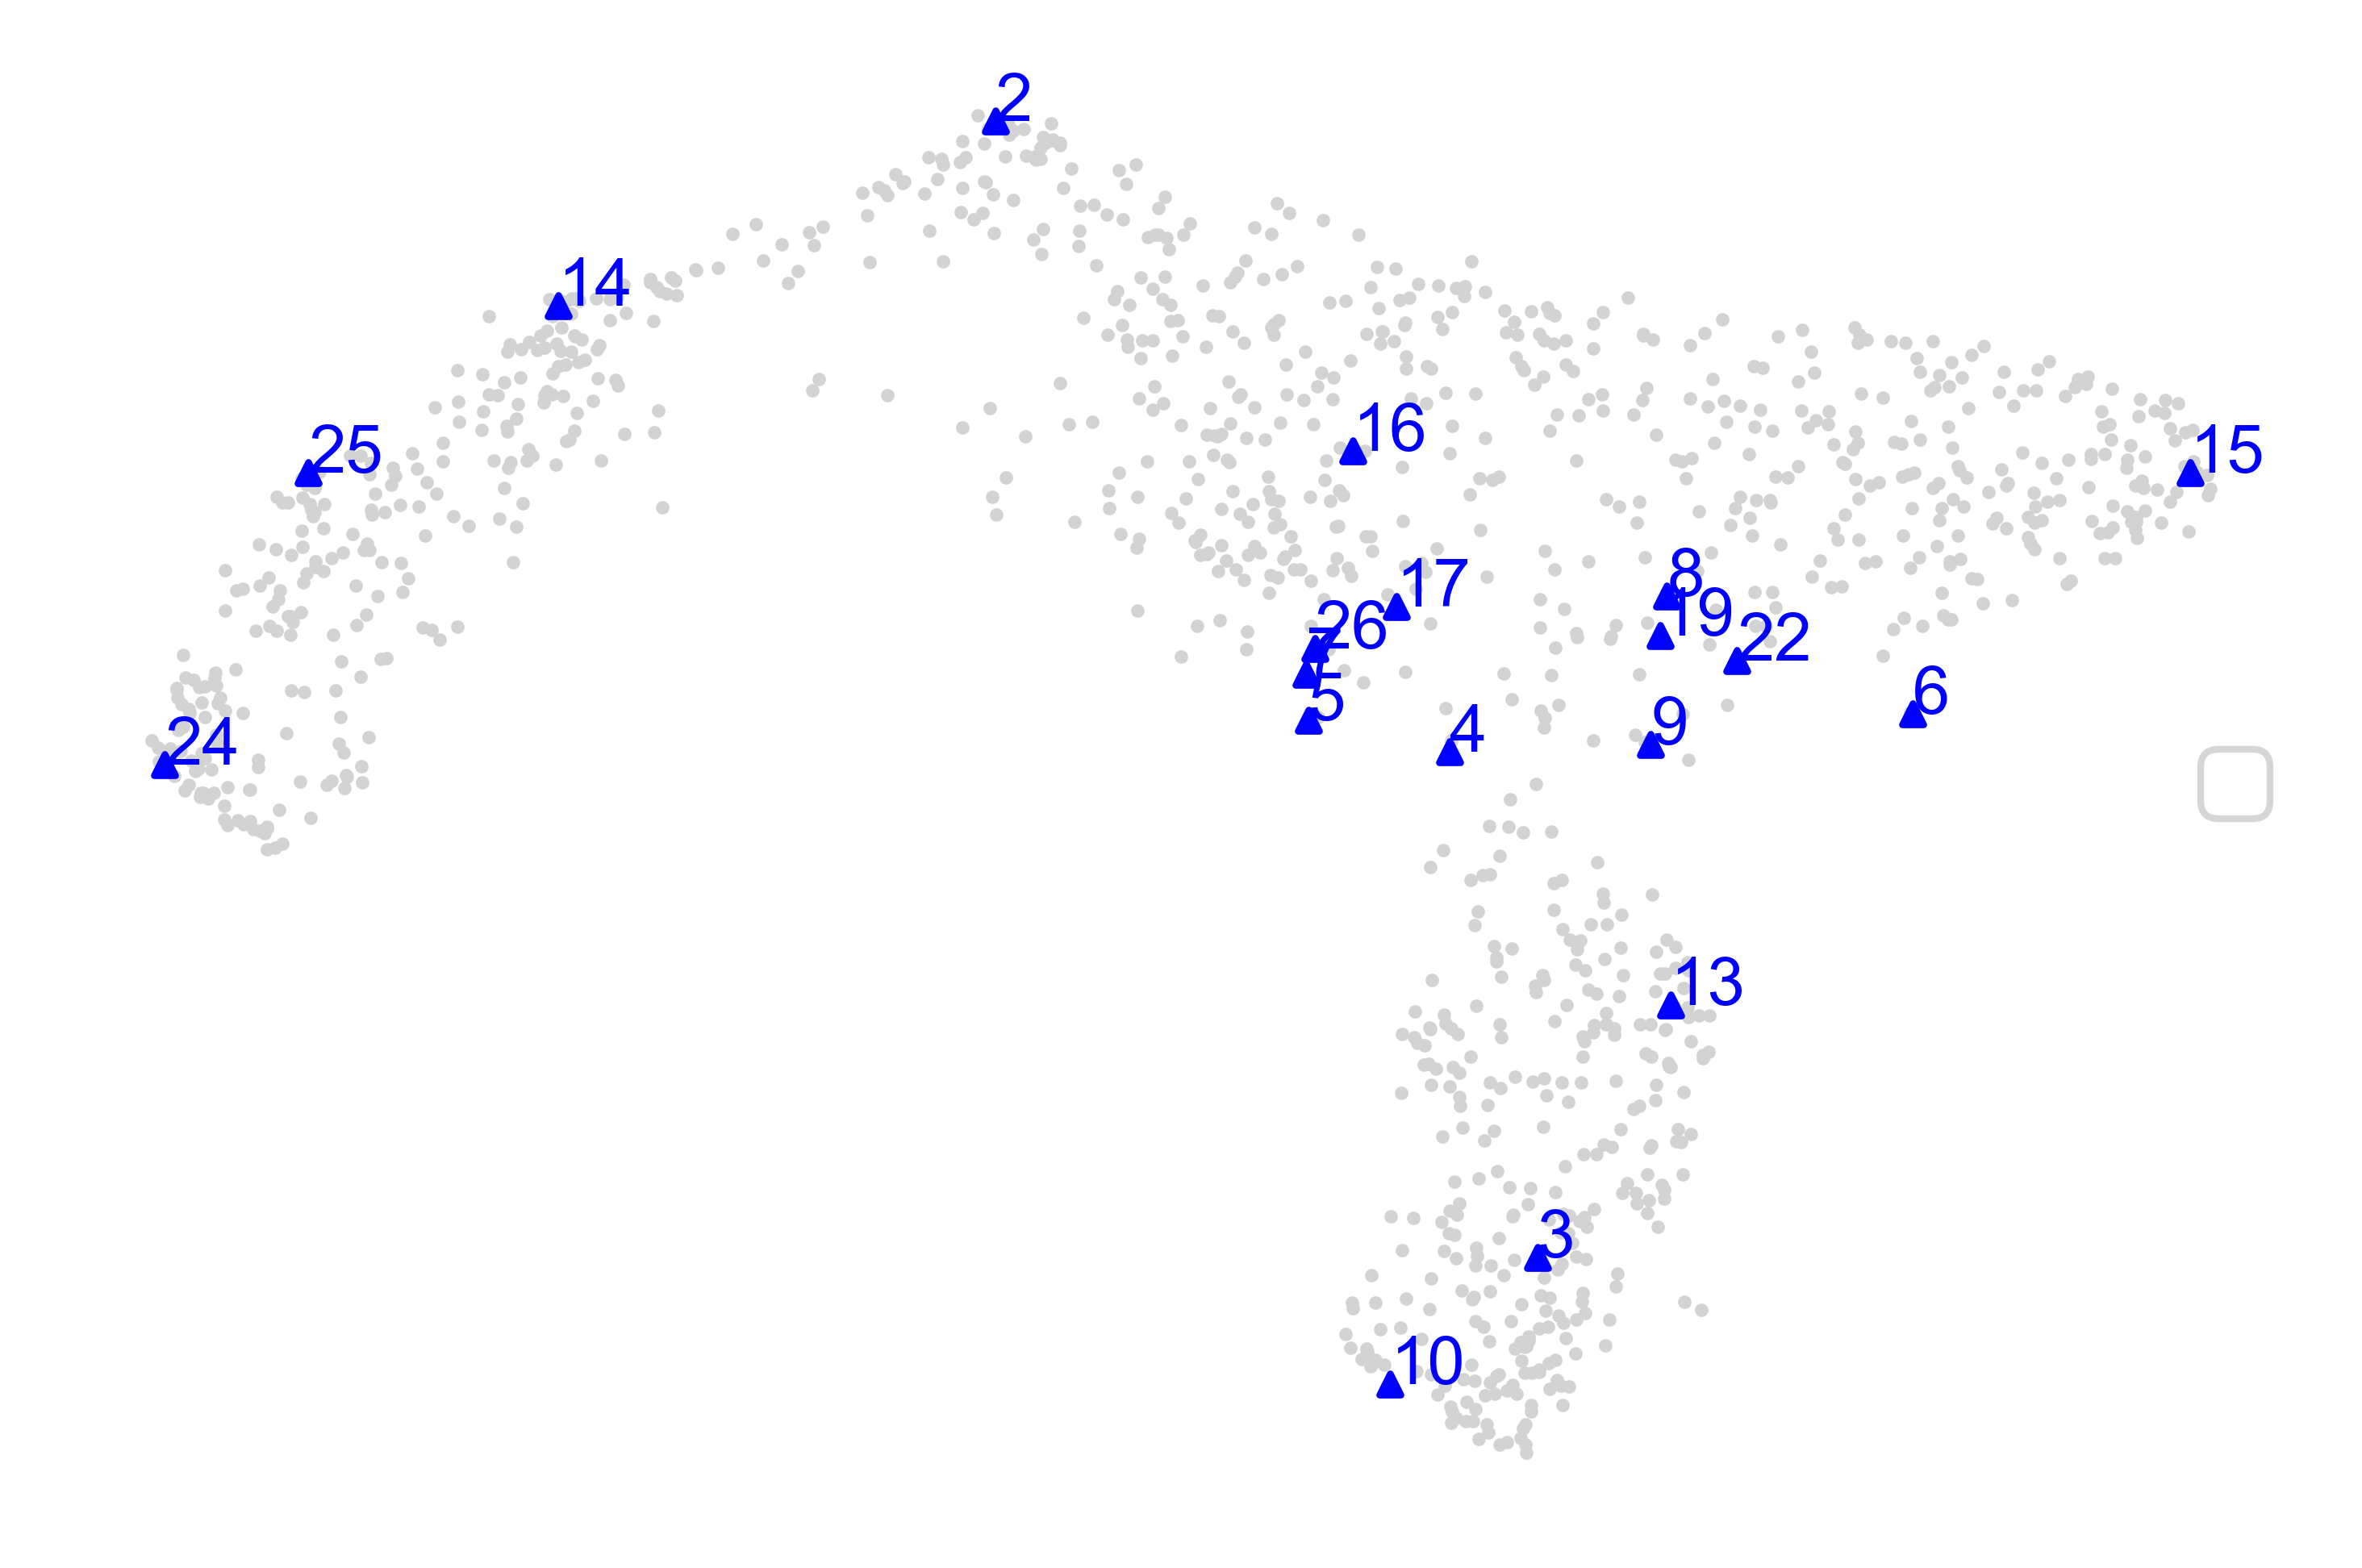

In [17]:
aa_model.plot_archetypes(do_3d=False, major=True, disp_cluster=False)

- Visualize archetypal - cell type mapping:

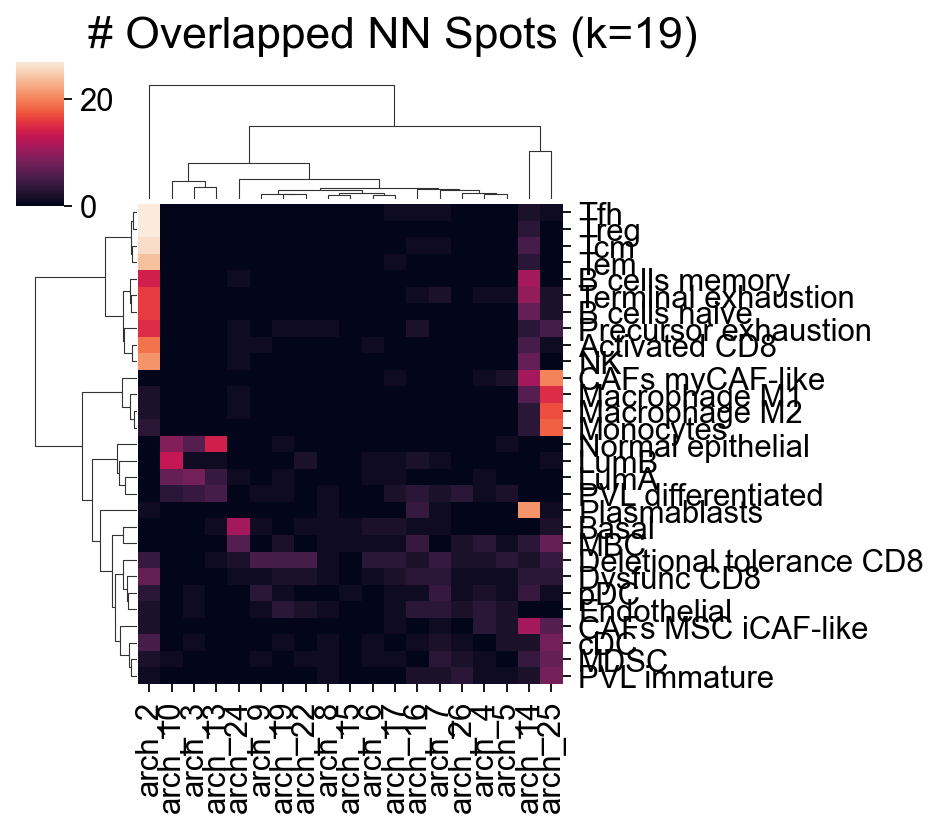

In [18]:
aa_model.plot_mapping(map_df)

- Application: appending marker genes Append archetypal marker genes with the best-aligned anchors:

In [ ]:
visium_args = utils.refine_anchors(
    visium_args,
    aa_model,
    #thld=0.7,  # alignment threshold
    n_genes=5,
    #n_iters=1
)

# Get updated adata & signatures
adata, adata_normed = visium_args.get_adata()
gene_sig = visium_args.gene_sig
cell_types = gene_sig.columns

## Run starfysh without histology integration



We perform `n_repeat` random restarts and select the best model with lowest loss for parameter `c` (inferred cell-type proportions):

### (1). Model parameters

In [20]:
import torch
n_repeats = 3
epochs = 200
patience = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### (2). Model training

Users can choose to run the one of the following `Starfysh` model without/with histology integration:

Without histology integration: setting `utils.run_starfysh(poe=False)` (default)

With histology integration: setting `utils.run_starfysh(poe=True)`

In [21]:
# Run models
model, loss = utils.run_starfysh(visium_args,
                                 n_repeats=n_repeats,
                                 epochs=epochs,
                                 #patience=patience,
                                 device=device
                                )

[2024-08-30 20:15:18] Running Starfysh with 3 restarts, choose the model with best parameters...
[2024-08-30 20:15:18] Initializing model parameters...
Training Epochs:   5%|▌         | 10/200 [00:04<01:32,  2.06it/s]

Epoch[10/200], train_loss: 3490.9582, train_reconst: 3221.3334, train_u: 17.9938,train_z: 25.6617,train_c: 199.7520,train_l: 26.2174


Training Epochs:  10%|█         | 20/200 [00:09<01:27,  2.06it/s]

Epoch[20/200], train_loss: 2108.3944, train_reconst: 1894.7217, train_u: 17.9194,train_z: 23.3753,train_c: 169.5878,train_l: 2.7902


Training Epochs:  15%|█▌        | 30/200 [00:14<01:22,  2.05it/s]

Epoch[30/200], train_loss: 1765.6603, train_reconst: 1570.7852, train_u: 17.8466,train_z: 21.6337,train_c: 154.2738,train_l: 1.1209


Training Epochs:  20%|██        | 40/200 [00:19<01:20,  1.98it/s]

Epoch[40/200], train_loss: 1733.2109, train_reconst: 1546.0455, train_u: 17.7864,train_z: 20.0372,train_c: 147.9223,train_l: 1.4195


Training Epochs:  25%|██▌       | 50/200 [00:25<01:25,  1.75it/s]

Epoch[50/200], train_loss: 1715.3109, train_reconst: 1532.1562, train_u: 17.7368,train_z: 19.2974,train_c: 144.5076,train_l: 1.6129


Training Epochs:  30%|███       | 60/200 [00:31<01:20,  1.75it/s]

Epoch[60/200], train_loss: 1698.8605, train_reconst: 1519.2789, train_u: 17.6968,train_z: 18.9038,train_c: 141.2221,train_l: 1.7591


Training Epochs:  35%|███▌      | 70/200 [00:36<01:14,  1.75it/s]

Epoch[70/200], train_loss: 1686.9498, train_reconst: 1508.5263, train_u: 17.6644,train_z: 18.8268,train_c: 140.0840,train_l: 1.8483


Training Epochs:  40%|████      | 80/200 [00:42<01:08,  1.75it/s]

Epoch[80/200], train_loss: 1674.9727, train_reconst: 1497.4797, train_u: 17.6380,train_z: 18.5378,train_c: 139.3780,train_l: 1.9392


Training Epochs:  45%|████▌     | 90/200 [00:48<01:02,  1.75it/s]

Epoch[90/200], train_loss: 1666.4966, train_reconst: 1490.2158, train_u: 17.6150,train_z: 18.3807,train_c: 138.2688,train_l: 2.0163


Training Epochs:  50%|█████     | 100/200 [00:54<00:57,  1.75it/s]

Epoch[100/200], train_loss: 1668.7559, train_reconst: 1493.4065, train_u: 17.5971,train_z: 18.1943,train_c: 137.4736,train_l: 2.0844


Training Epochs:  55%|█████▌    | 110/200 [00:59<00:51,  1.75it/s]

Epoch[110/200], train_loss: 1662.3459, train_reconst: 1488.1466, train_u: 17.5824,train_z: 17.7968,train_c: 136.6870,train_l: 2.1330


Training Epochs:  60%|██████    | 120/200 [01:05<00:45,  1.75it/s]

Epoch[120/200], train_loss: 1660.4514, train_reconst: 1486.6055, train_u: 17.5705,train_z: 17.9425,train_c: 136.1627,train_l: 2.1702


Training Epochs:  65%|██████▌   | 130/200 [01:11<00:39,  1.75it/s]

Epoch[130/200], train_loss: 1663.8893, train_reconst: 1489.7117, train_u: 17.5609,train_z: 17.7712,train_c: 136.6321,train_l: 2.2134


Training Epochs:  70%|███████   | 140/200 [01:16<00:34,  1.75it/s]

Epoch[140/200], train_loss: 1662.0375, train_reconst: 1487.8504, train_u: 17.5531,train_z: 18.0914,train_c: 136.2991,train_l: 2.2435


Training Epochs:  75%|███████▌  | 150/200 [01:22<00:28,  1.75it/s]

Epoch[150/200], train_loss: 1657.0409, train_reconst: 1483.5592, train_u: 17.5466,train_z: 17.6962,train_c: 135.9730,train_l: 2.2660


Training Epochs:  80%|████████  | 160/200 [01:28<00:22,  1.78it/s]

Epoch[160/200], train_loss: 1659.4122, train_reconst: 1485.7647, train_u: 17.5412,train_z: 17.7207,train_c: 136.0941,train_l: 2.2916


Training Epochs:  85%|████████▌ | 170/200 [01:33<00:16,  1.77it/s]

Epoch[170/200], train_loss: 1654.4409, train_reconst: 1481.7205, train_u: 17.5370,train_z: 17.6184,train_c: 135.2536,train_l: 2.3115


Training Epochs:  90%|█████████ | 180/200 [01:39<00:11,  1.77it/s]

Epoch[180/200], train_loss: 1656.3850, train_reconst: 1483.2924, train_u: 17.5335,train_z: 17.6977,train_c: 135.5281,train_l: 2.3333


Training Epochs:  95%|█████████▌| 190/200 [01:45<00:05,  1.77it/s]

Epoch[190/200], train_loss: 1658.1092, train_reconst: 1484.6301, train_u: 17.5306,train_z: 17.5962,train_c: 136.0102,train_l: 2.3421


Training Epochs: 100%|██████████| 200/200 [01:51<00:00,  1.80it/s]
[2024-08-30 20:17:09] Saving the best-performance model...
[2024-08-30 20:17:09]  === Finished training === 

[2024-08-30 20:17:09] Initializing model parameters...


Epoch[200/200], train_loss: 1658.3536, train_reconst: 1484.1678, train_u: 17.5282,train_z: 17.6687,train_c: 136.6331,train_l: 2.3558


Training Epochs:   5%|▌         | 10/200 [00:05<01:47,  1.77it/s]

Epoch[10/200], train_loss: 3490.9582, train_reconst: 3221.3334, train_u: 17.9938,train_z: 25.6617,train_c: 199.7520,train_l: 26.2174


Training Epochs:  10%|█         | 20/200 [00:11<01:41,  1.77it/s]

Epoch[20/200], train_loss: 2108.3944, train_reconst: 1894.7217, train_u: 17.9194,train_z: 23.3753,train_c: 169.5878,train_l: 2.7902


Training Epochs:  15%|█▌        | 30/200 [00:17<01:35,  1.78it/s]

Epoch[30/200], train_loss: 1765.6603, train_reconst: 1570.7852, train_u: 17.8466,train_z: 21.6337,train_c: 154.2738,train_l: 1.1209


Training Epochs:  20%|██        | 40/200 [00:22<01:31,  1.74it/s]

Epoch[40/200], train_loss: 1733.2109, train_reconst: 1546.0455, train_u: 17.7864,train_z: 20.0372,train_c: 147.9223,train_l: 1.4195


Training Epochs:  25%|██▌       | 50/200 [00:28<01:24,  1.77it/s]

Epoch[50/200], train_loss: 1715.3109, train_reconst: 1532.1562, train_u: 17.7368,train_z: 19.2974,train_c: 144.5076,train_l: 1.6129


Training Epochs:  30%|███       | 60/200 [00:34<01:18,  1.79it/s]

Epoch[60/200], train_loss: 1698.8605, train_reconst: 1519.2789, train_u: 17.6968,train_z: 18.9038,train_c: 141.2221,train_l: 1.7591


Training Epochs:  35%|███▌      | 70/200 [00:39<01:12,  1.79it/s]

Epoch[70/200], train_loss: 1686.9498, train_reconst: 1508.5263, train_u: 17.6644,train_z: 18.8268,train_c: 140.0840,train_l: 1.8483


Training Epochs:  40%|████      | 80/200 [00:45<01:10,  1.71it/s]

Epoch[80/200], train_loss: 1674.9727, train_reconst: 1497.4797, train_u: 17.6380,train_z: 18.5378,train_c: 139.3780,train_l: 1.9392


Training Epochs:  45%|████▌     | 90/200 [00:51<01:03,  1.72it/s]

Epoch[90/200], train_loss: 1666.4966, train_reconst: 1490.2158, train_u: 17.6150,train_z: 18.3807,train_c: 138.2688,train_l: 2.0163


Training Epochs:  50%|█████     | 100/200 [00:57<00:59,  1.67it/s]

Epoch[100/200], train_loss: 1668.7559, train_reconst: 1493.4065, train_u: 17.5971,train_z: 18.1943,train_c: 137.4736,train_l: 2.0844


Training Epochs:  55%|█████▌    | 110/200 [01:03<00:50,  1.77it/s]

Epoch[110/200], train_loss: 1662.3459, train_reconst: 1488.1466, train_u: 17.5824,train_z: 17.7968,train_c: 136.6870,train_l: 2.1330


Training Epochs:  60%|██████    | 120/200 [01:08<00:45,  1.76it/s]

Epoch[120/200], train_loss: 1660.4514, train_reconst: 1486.6055, train_u: 17.5705,train_z: 17.9425,train_c: 136.1627,train_l: 2.1702


Training Epochs:  65%|██████▌   | 130/200 [01:14<00:41,  1.70it/s]

Epoch[130/200], train_loss: 1663.8893, train_reconst: 1489.7117, train_u: 17.5609,train_z: 17.7712,train_c: 136.6321,train_l: 2.2134


Training Epochs:  70%|███████   | 140/200 [01:20<00:34,  1.73it/s]

Epoch[140/200], train_loss: 1662.0375, train_reconst: 1487.8504, train_u: 17.5531,train_z: 18.0914,train_c: 136.2991,train_l: 2.2435


Training Epochs:  75%|███████▌  | 150/200 [01:26<00:29,  1.67it/s]

Epoch[150/200], train_loss: 1657.0409, train_reconst: 1483.5592, train_u: 17.5466,train_z: 17.6962,train_c: 135.9730,train_l: 2.2660


Training Epochs:  80%|████████  | 160/200 [01:32<00:22,  1.75it/s]

Epoch[160/200], train_loss: 1659.4122, train_reconst: 1485.7647, train_u: 17.5412,train_z: 17.7207,train_c: 136.0941,train_l: 2.2916


Training Epochs:  85%|████████▌ | 170/200 [01:38<00:17,  1.69it/s]

Epoch[170/200], train_loss: 1654.4409, train_reconst: 1481.7205, train_u: 17.5370,train_z: 17.6184,train_c: 135.2536,train_l: 2.3115


Training Epochs:  90%|█████████ | 180/200 [01:44<00:11,  1.67it/s]

Epoch[180/200], train_loss: 1656.3850, train_reconst: 1483.2924, train_u: 17.5335,train_z: 17.6977,train_c: 135.5281,train_l: 2.3333


Training Epochs:  95%|█████████▌| 190/200 [01:50<00:05,  1.67it/s]

Epoch[190/200], train_loss: 1658.1092, train_reconst: 1484.6301, train_u: 17.5306,train_z: 17.5962,train_c: 136.0102,train_l: 2.3421


Training Epochs: 100%|██████████| 200/200 [01:56<00:00,  1.72it/s]
[2024-08-30 20:19:06] Saving the best-performance model...
[2024-08-30 20:19:06]  === Finished training === 

[2024-08-30 20:19:06] Initializing model parameters...


Epoch[200/200], train_loss: 1658.3536, train_reconst: 1484.1678, train_u: 17.5282,train_z: 17.6687,train_c: 136.6331,train_l: 2.3558


Training Epochs:   5%|▌         | 10/200 [00:06<01:54,  1.66it/s]

Epoch[10/200], train_loss: 3490.9582, train_reconst: 3221.3334, train_u: 17.9938,train_z: 25.6617,train_c: 199.7520,train_l: 26.2174


Training Epochs:  10%|█         | 20/200 [00:11<01:45,  1.71it/s]

Epoch[20/200], train_loss: 2108.3944, train_reconst: 1894.7217, train_u: 17.9194,train_z: 23.3753,train_c: 169.5878,train_l: 2.7902


Training Epochs:  15%|█▌        | 30/200 [00:17<01:43,  1.65it/s]

Epoch[30/200], train_loss: 1765.6603, train_reconst: 1570.7852, train_u: 17.8466,train_z: 21.6337,train_c: 154.2738,train_l: 1.1209


Training Epochs:  20%|██        | 40/200 [00:23<01:33,  1.71it/s]

Epoch[40/200], train_loss: 1733.2109, train_reconst: 1546.0455, train_u: 17.7864,train_z: 20.0372,train_c: 147.9223,train_l: 1.4195


Training Epochs:  25%|██▌       | 50/200 [00:29<01:28,  1.70it/s]

Epoch[50/200], train_loss: 1715.3109, train_reconst: 1532.1562, train_u: 17.7368,train_z: 19.2974,train_c: 144.5076,train_l: 1.6129


Training Epochs:  30%|███       | 60/200 [00:35<01:22,  1.69it/s]

Epoch[60/200], train_loss: 1698.8605, train_reconst: 1519.2789, train_u: 17.6968,train_z: 18.9038,train_c: 141.2221,train_l: 1.7591


Training Epochs:  35%|███▌      | 70/200 [00:41<01:14,  1.75it/s]

Epoch[70/200], train_loss: 1686.9498, train_reconst: 1508.5263, train_u: 17.6644,train_z: 18.8268,train_c: 140.0840,train_l: 1.8483


Training Epochs:  40%|████      | 80/200 [00:47<01:12,  1.65it/s]

Epoch[80/200], train_loss: 1674.9727, train_reconst: 1497.4797, train_u: 17.6380,train_z: 18.5378,train_c: 139.3780,train_l: 1.9392


Training Epochs:  45%|████▌     | 90/200 [00:53<01:06,  1.65it/s]

Epoch[90/200], train_loss: 1666.4966, train_reconst: 1490.2158, train_u: 17.6150,train_z: 18.3807,train_c: 138.2688,train_l: 2.0163


Training Epochs:  50%|█████     | 100/200 [00:59<00:59,  1.69it/s]

Epoch[100/200], train_loss: 1668.7559, train_reconst: 1493.4065, train_u: 17.5971,train_z: 18.1943,train_c: 137.4736,train_l: 2.0844


Training Epochs:  55%|█████▌    | 110/200 [01:05<00:53,  1.68it/s]

Epoch[110/200], train_loss: 1662.3459, train_reconst: 1488.1466, train_u: 17.5824,train_z: 17.7968,train_c: 136.6870,train_l: 2.1330


Training Epochs:  60%|██████    | 120/200 [01:11<00:47,  1.67it/s]

Epoch[120/200], train_loss: 1660.4514, train_reconst: 1486.6055, train_u: 17.5705,train_z: 17.9425,train_c: 136.1627,train_l: 2.1702


Training Epochs:  65%|██████▌   | 130/200 [01:17<00:40,  1.71it/s]

Epoch[130/200], train_loss: 1663.8893, train_reconst: 1489.7117, train_u: 17.5609,train_z: 17.7712,train_c: 136.6321,train_l: 2.2134


Training Epochs:  70%|███████   | 140/200 [01:23<00:36,  1.66it/s]

Epoch[140/200], train_loss: 1662.0375, train_reconst: 1487.8504, train_u: 17.5531,train_z: 18.0914,train_c: 136.2991,train_l: 2.2435


Training Epochs:  75%|███████▌  | 150/200 [01:29<00:30,  1.65it/s]

Epoch[150/200], train_loss: 1657.0409, train_reconst: 1483.5592, train_u: 17.5466,train_z: 17.6962,train_c: 135.9730,train_l: 2.2660


Training Epochs:  80%|████████  | 160/200 [01:35<00:24,  1.65it/s]

Epoch[160/200], train_loss: 1659.4122, train_reconst: 1485.7647, train_u: 17.5412,train_z: 17.7207,train_c: 136.0941,train_l: 2.2916


Training Epochs:  85%|████████▌ | 170/200 [01:41<00:18,  1.66it/s]

Epoch[170/200], train_loss: 1654.4409, train_reconst: 1481.7205, train_u: 17.5370,train_z: 17.6184,train_c: 135.2536,train_l: 2.3115


Training Epochs:  90%|█████████ | 180/200 [01:47<00:12,  1.66it/s]

Epoch[180/200], train_loss: 1656.3850, train_reconst: 1483.2924, train_u: 17.5335,train_z: 17.6977,train_c: 135.5281,train_l: 2.3333


Training Epochs:  95%|█████████▌| 190/200 [01:53<00:06,  1.65it/s]

Epoch[190/200], train_loss: 1658.1092, train_reconst: 1484.6301, train_u: 17.5306,train_z: 17.5962,train_c: 136.0102,train_l: 2.3421


Training Epochs: 100%|██████████| 200/200 [01:59<00:00,  1.68it/s]
[2024-08-30 20:21:05] Saving the best-performance model...
[2024-08-30 20:21:05]  === Finished training === 



Epoch[200/200], train_loss: 1658.3536, train_reconst: 1484.1678, train_u: 17.5282,train_z: 17.6687,train_c: 136.6331,train_l: 2.3558


### Downstream analysis

### Parse Starfysh inference output

In [22]:
adata, adata_normed = visium_args.get_adata()
inference_outputs, generative_outputs,adata_ = sf_model.model_eval(model,
                                                            adata,
                                                            visium_args,
                                                            poe=False,
                                                            device=device)

### Visualize starfysh deconvolution results

**Gene sig mean vs. inferred prop**

<AxesSubplot: title={'center': 'Macrophage M1'}, xlabel='Gene signature mean', ylabel='Predicted proportions'>

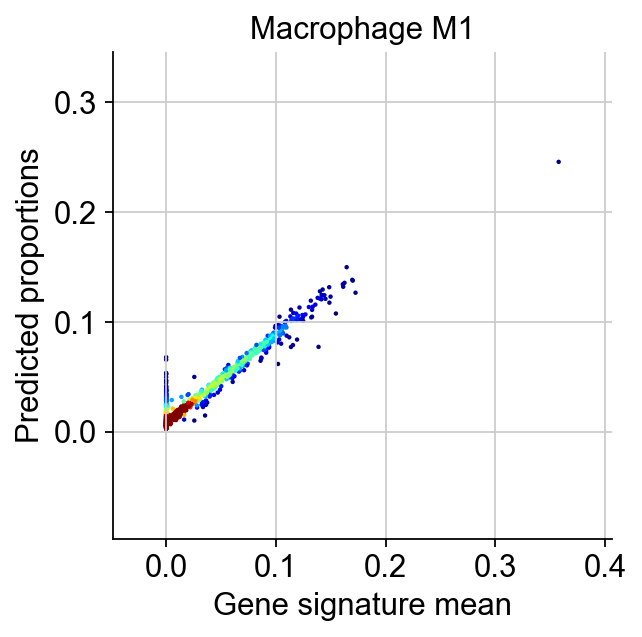

In [31]:
import numpy as np
n_cell_types = gene_sig.shape[1]
idx = np.random.randint(0, n_cell_types)
post_analysis.gene_mean_vs_inferred_prop(inference_outputs,
                                         visium_args,
                                         idx=idx,
                                         figsize=(4,4)
                                        )

### Spatial visualizations:

Inferred density on Spatial map:

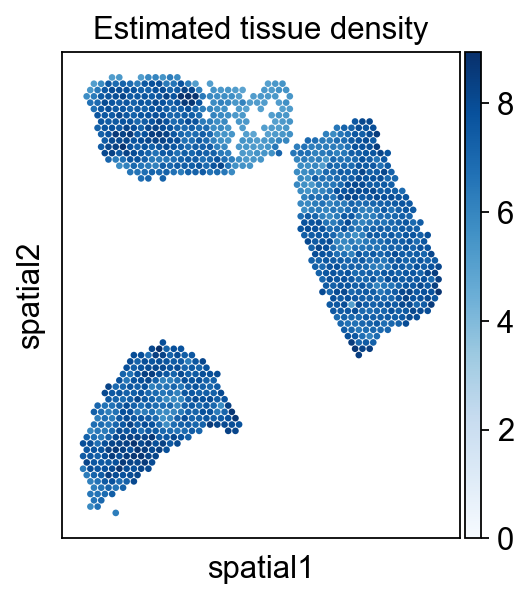

In [24]:
plot_utils.pl_spatial_inf_feature(adata_, feature='ql_m', cmap='Blues')

**Inferred cell-type proportions (spatial map):**


In [25]:
def cell2proportion(adata):
    adata_plot=sc.AnnData(adata.X)
    adata_plot.obs=utils.extract_feature(adata_, 'qc_m').obs.copy()
    adata_plot.var=adata.var.copy()
    adata_plot.obsm=adata.obsm.copy()
    adata_plot.obsp=adata.obsp.copy()
    adata_plot.uns=adata.uns.copy()
    return adata_plot
adata_plot=cell2proportion(adata_)

In [26]:
adata_plot

AnnData object with n_obs × n_vars = 1162 × 2609
    obs: 'Basal', 'LumA', 'LumB', 'MBC', 'Normal epithelial', 'Tcm', 'Tem', 'Tfh', 'Treg', 'Activated CD8', 'Deletional tolerance CD8', 'Dysfunc CD8', 'Terminal exhaustion', 'Precursor exhaustion', 'NK', 'B cells memory', 'B cells naive', 'Macrophage M1', 'Macrophage M2', 'Plasmablasts', 'MDSC', 'Monocytes', 'cDC', 'pDC', 'CAFs MSC iCAF-like', 'CAFs myCAF-like', 'PVL differentiated', 'PVL immature', 'Endothelial'
    var: 'features', 'highly_variable'
    uns: 'pca', 'neighbors', 'umap', 'cell_types', 'spatial', 'qu'
    obsm: 'X_pca', 'X_umap', 'spatial', 'px', 'qc_m', 'qc', 'qz_m', 'qz_m_ct', 'qz_logv', 'qz_logv_ct', 'qz', 'ql_m', 'ql_logv', 'ql', 'px_rate', 'pc_p', 'xs_k', 'z_umap'
    obsp: 'distances', 'connectivities'

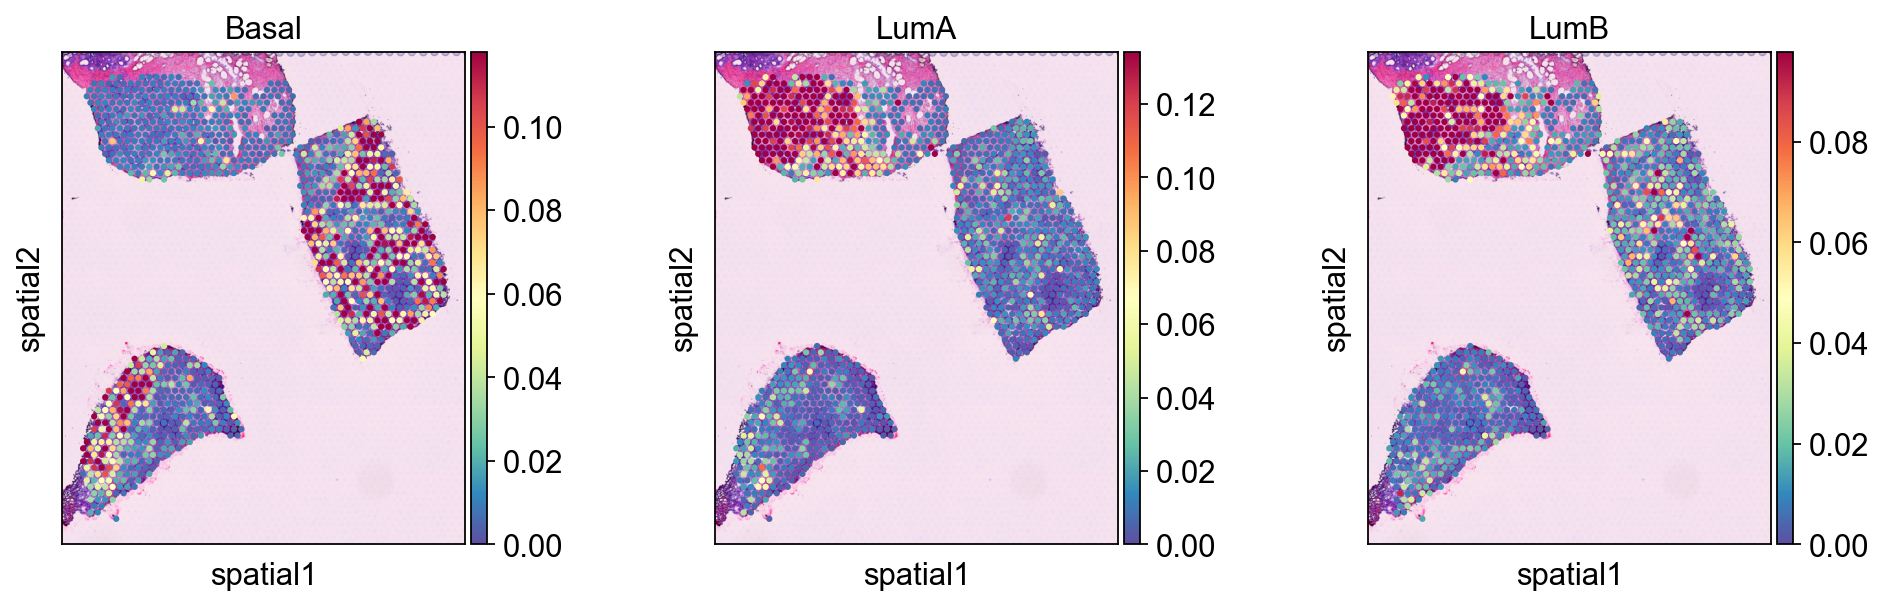

In [27]:
sc.pl.spatial(adata_plot, cmap='Spectral_r',
                  # show first 8 cell types
                  color=['Basal','LumA','LumB'],
                  ncols=4, size=1.3,
                  img_key='hires',
                  vmin=0, vmax='p90'
                 )

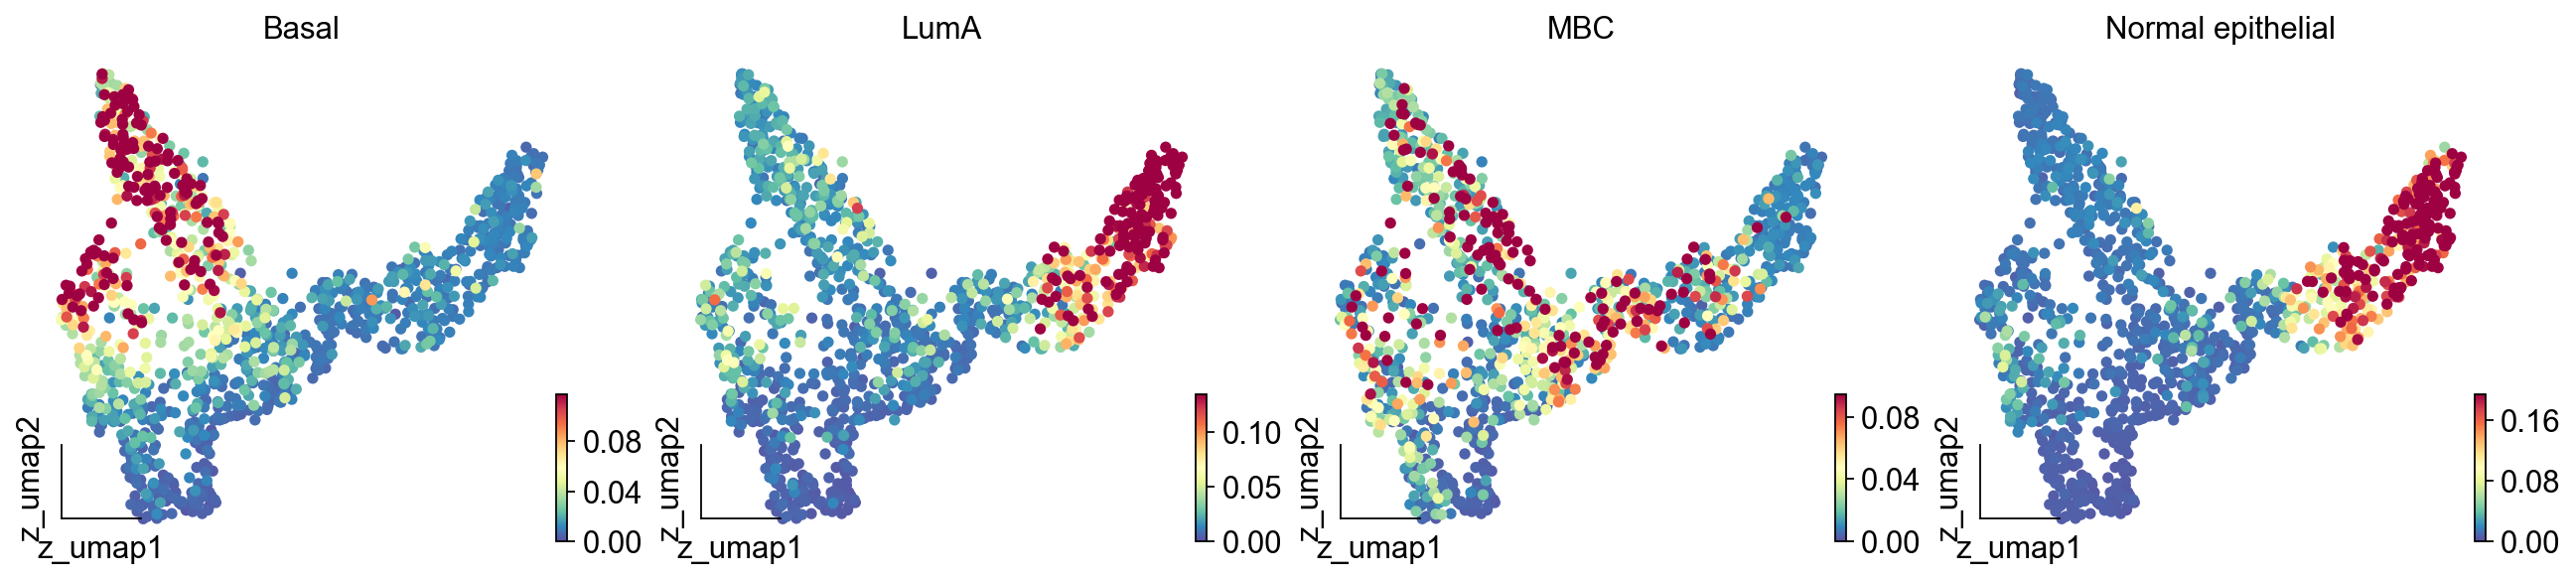

In [28]:
ov.pl.embedding(adata_plot,
               basis='z_umap',
                color=['Basal', 'LumA', 'MBC', 'Normal epithelial'],
               frameon='small',
                vmin=0, vmax='p90',
                cmap='Spectral_r',
               )

In [29]:
pred_exprs = sf_model.model_ct_exp(model,
                                   adata,
                                   visium_args,
                                   device=device)

Plot spot-level expression (e.g. `IL7R` from *Effector Memory T cells (Tem)*):


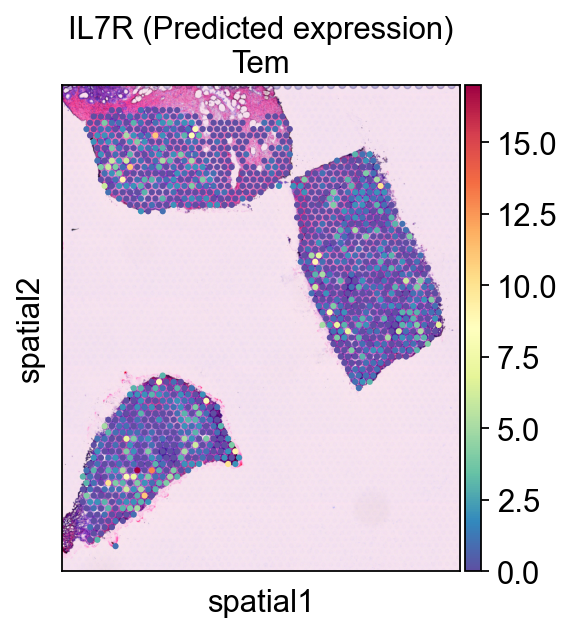

In [30]:
gene='IL7R'
gene_celltype='Tem'
adata_.layers[f'infer_{gene_celltype}']=pred_exprs[gene_celltype]

sc.pl.spatial(adata_, cmap='Spectral_r',
                  # show first 8 cell types
                  color=gene,
                  title=f'{gene} (Predicted expression)\n{gene_celltype}',
                  layer=f'infer_{gene_celltype}',
                  ncols=4, size=1.3,
                  img_key='hires',
                  #vmin=0, vmax='p90'
                 )

### Save model & inferred parameters

In [ ]:
# Specify output directory
outdir = './results/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

# save the model
torch.save(model.state_dict(), os.path.join(outdir, 'starfysh_model.pt'))

# save `adata` object with inferred parameters
adata.write(os.path.join(outdir, 'st.h5ad'))